<a href="https://colab.research.google.com/github/kehinde-ezekiel/REU-GoogleColab/blob/main/DataWrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Lecture 1: Wrangling. In this lecture notebook, we will test the hypotheses that the CEOs of major companies are typically in their 40s or oldder. To do this, we will identify top comanies, find their CEOs, extract their ages, and look at the distribution of their ages.

In [33]:
#Let start by intsalling some libraries that are useful for processing web data.

#For crawling pages
!pip install scrapy

# # Optional, for parrallel execution
!pip install swifter

# # For string similarity
!pip install py_stringsimjoin

# # lxml to parse xml tree
!pip install lxml

!pip install pandas
!pip install numpy
!pip install matplotlib

In [34]:
# Here are some imports for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib

# Pandas dataframes
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistics database
import sqlite3

# Crawler for multiple web pages at once
import scrapy
from scrapy.crawler import CrawlerProcess

#Try to parallalize the computation
import swifter

#Approximate string maching
import py_stringsimjoin as ssj
import py_stringmatching as sm

# data visualization
import matplotlib

# import urllib and etree for download and parsing
from lxml import etree

##Acquiring Data About Companies and CEOs

In [35]:
data = urllib.request.urlopen(\
                              'https://gist.githubusercontent.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv')

company_data_df = pd.read_csv(data)


In [36]:
# Persist it to an SQLite database, and read it back.
conn = sqlite3.connect('local.db')

company_data_df.to_sql("companies", conn, if_exists="replace", index=False)

pd.read_sql_query('select * from companies', conn)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1 750 000,acquired,USA,NY,New York City,New York,1,01/06/2012,2012-06,2012-Q2,2012.0,30/06/2012,30/06/2012
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4 000 000,operating,USA,CA,Los Angeles,Los Angeles,2,None,None,None,NaN,04/06/2010,23/09/2010
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40 000,operating,EST,None,Tallinn,Tallinn,1,26/10/2012,2012-10,2012-Q4,2012.0,09/08/2012,09/08/2012
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|iPhone|Apps|Mobile|iOS|E-Commerce|,Electronics,1 500 000,operating,GBR,None,London,London,1,01/04/2011,2011-04,2011-Q2,2011.0,01/04/2011,01/04/2011
4,/organization/n-plusn,+n (PlusN),http://plusn.com,|Software|,Software,1 200 000,operating,USA,NY,New York City,New York,2,01/01/2012,2012-01,2012-Q1,2012.0,29/08/2012,04/09/2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47753,/organization/zzish,Zzish,http://www.zzish.com,|Analytics|Gamification|Developer APIs|iOS|Android|Education|,Education,320 000,operating,GBR,None,London,London,1,28/01/2013,2013-01,2013-Q1,2013.0,24/03/2014,24/03/2014
47754,/organization/zznode-science-and-technology-co-ltd,ZZNode Science and Technology,http://www.zznode.com,|Enterprise Software|,Enterprise Software,1 587 301,operating,CHN,None,Beijing,Beijing,1,None,None,None,NaN,01/04/2012,01/04/2012
47755,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,|Web Development|Advertising|Wireless|Mobile|,Web Development,97 398,operating,HRV,None,Split,Split,5,13/05/2012,2012-05,2012-Q2,2012.0,01/11/2011,10/09/2014
47756,/organization/a-list-games,[a]list games,http://www.alistgames.com,|Games|,Games,9 300 000,operating,None,None,None,None,1,None,None,None,NaN,21/11/2011,21/11/2011


In [37]:
# Now let's read a HTML table containing information about CEOs

company_ceos_df = pd.read_html('https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/List_of_chief_executive_officers.html#List_of_CEOs') [0]

company_ceos_df

,Company,Executive,Title,Since,Notes,Updated
0,Accenture,Julie Sweet,Interim CEO[1],2019,"Succeeded Pierre Nanterme, Passed Away",2019-01-31
1,Aditya Birla Group,Kumar Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01
2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple Inc.,2018-10-01
3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01
4,Airbus,Tom Enders,CEO[5],2012,Succeeded Louis Gallois,2017-11-14
...,...,...,...,...,...,...
180,Williams-Sonoma,Laura J. Alber,President and CEO[168],2010,Replaced W. Howard Lester,2017-11-11
181,Wipro Technologies Limited,Abidali Neemuchwala,CEO[169],2016,Previously with Tata Consultancy Services,2017-11-11
182,WWE,Vince McMahon,Chairman and CEO[170],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980-1993,2017-11-11
183,Yum! Brands,Greg Creed,CEO[171],2015,Previously CEO for Taco Bell,2017-11-11


In [38]:
crawl_list = []

for executive in company_ceos_df['Executive']:
  crawl_list.append('https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/' + executive.replace(' ', '_') + '.html')
  

crawl_list



['https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/Julie_Sweet.html',
 'https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/Kumar_Birla.html',
 'https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/Shantanu_Narayen.html',
 'https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/Garo_H._Armen.html',
 'https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/Tom_Enders.html',
 'https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autoload-data/data-wrangling/en.wikipedia.org/wiki/Daniel_Zhang.html',
 'https://raw.githubu

In [39]:
# use urllib to crawl all pages in crawl_list, and store the response of page
# in list_pages

pages = []

for url in crawl_list:
  page = url.split("/") [-1] # extract the person name at the end of the url
  print('Looking at file %s' % page)
  # split the url into different parts, and convert the person name into ascii code
  url_list = list(urllib.parse.urlsplit(url))
  url_list[2] = urllib.parse.quote(url_list[2])
  url_ascii = urllib.parse.urlunsplit(url_list)
  try:
   response = urllib.request.urlopen(url_ascii)
  # save the page and url for later use
   pages.append(response)
  except urllib.error.URLError as e:
   print(e.reason)



Looking at file Julie_Sweet.html
Looking at file Kumar_Birla.html
Looking at file Shantanu_Narayen.html
Looking at file Garo_H._Armen.html
Looking at file Tom_Enders.html
Looking at file Daniel_Zhang.html
Looking at file Jeff_Bezos.html
Looking at file Lisa_Su.html
Looking at file Stephen_Squeri.html
Looking at file Doug_Parker.html
Looking at file Joseph_R._Swedish.html
Looking at file Tim_Cook.html
Looking at file Lakshmi_Niwas_Mittal.html
Looking at file Randall_L._Stephenson.html
Looking at file Charles_Woodburn.html
Looking at file Tapan_Singhel.html
Looking at file Carlos_Torres_Vila.html
Looking at file Brian_Moynihan.html
Looking at file Jes_Staley.html
Looking at file Warren_Buffett.html
Looking at file Hubert_Joly.html
Looking at file Sunil_Bharti_Mittal.html
Looking at file Stephen_A._Schwarzman.html
Looking at file Andrew_Mackenzie.html
Looking at file Harald_Krüger.html
Looking at file Charles_Scharf.html
Looking at file Dennis_Muilenburg.html
Looking at file Rich_Lesser.h

Populate a table with the name, we page URL, and birth date of each CEO

In [40]:
# Use etree.HTML(...) on the HTML content of each page to ger a DOM tree that
# can be processed via XPath to extract the bday information. Store the CEO name,
# webpage, and the birthday (born) in exec_df

# We first check that the HTML content has a table type vcard
# abd then extract the bday information. Id there is no birthday, the datetime
# value is Nat (not a type)

exec_df = pd.DataFrame(columns=['name','page','born'])

for page in pages:  
  
    tree = etree.HTML(page.read().decode("utf-8"))  #create a DOM tree of the page
    url = page.geturl()
    bday = tree.xpath('//table[contains(@class,"vcard")]//tbody/tr/td//span[@class="bday"]/text()')
    if (len(bday)>0):
        exec_df = exec_df.append({'name': url[url.rfind('/')+1:-5], 'page': url,
                   'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')}, ignore_index=True)
    else: 
            exec_df = exec_df.append({'name': url[url.rfind('/')+1:-5], 'page': url
                                      , 'born': None}, ignore_index=True)
        
exec_df

,name,page,born
0,Julie_Sweet,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT
1,Kumar_Birla,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1967-06-14
2,Shantanu_Narayen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1963-05-27
3,Garo_H._Armen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1953-01-31
4,Tom_Enders,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT
...,...,...,...
177,Laura_J._Alber,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT
178,Abidali_Neemuchwala,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT
179,Vince_McMahon,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1945-08-24
180,Greg_Creed,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT


##Cleaning and Manipulating the Tables

In [41]:
# Let's look at the name and birn data in exec_df. We do this via projection
# Notice also (e.g row 24) that special characters will cause issues

exec_df[['name','born']]

,name,born
0,Julie_Sweet,NaT
1,Kumar_Birla,1967-06-14
2,Shantanu_Narayen,1963-05-27
3,Garo_H._Armen,1953-01-31
4,Tom_Enders,NaT
...,...,...
177,Laura_J._Alber,NaT
178,Abidali_Neemuchwala,NaT
179,Vince_McMahon,1945-08-24
180,Greg_Creed,NaT


In [42]:
# clean the name by removing underscores and store in a new file called clean_name

exec_df['clean_name'] = exec_df['name'].apply(lambda x: x.replace('_',' '))

exec_df


,name,page,born,clean_name
0,Julie_Sweet,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Julie Sweet
1,Kumar_Birla,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1967-06-14,Kumar Birla
2,Shantanu_Narayen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1963-05-27,Shantanu Narayen
3,Garo_H._Armen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1953-01-31,Garo H. Armen
4,Tom_Enders,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Tom Enders
...,...,...,...,...
177,Laura_J._Alber,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Laura J. Alber
178,Abidali_Neemuchwala,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Abidali Neemuchwala
179,Vince_McMahon,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1945-08-24,Vince McMahon
180,Greg_Creed,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Greg Creed


In [43]:
# We can do the same via SQL. For the example we'll save dataframe first, and then execute just the name and clean_name using SQL

exec_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('select name, replace(name, "_", " ") as clean_name from temp_exec', conn)


,name,clean_name
0,Julie_Sweet,Julie Sweet
1,Kumar_Birla,Kumar Birla
2,Shantanu_Narayen,Shantanu Narayen
3,Garo_H._Armen,Garo H. Armen
4,Tom_Enders,Tom Enders
...,...,...
177,Laura_J._Alber,Laura J. Alber
178,Abidali_Neemuchwala,Abidali Neemuchwala
179,Vince_McMahon,Vince McMahon
180,Greg_Creed,Greg Creed


In [44]:
exec_df['clean_name']

0              Julie Sweet
1              Kumar Birla
2         Shantanu Narayen
3            Garo H. Armen
4               Tom Enders
              ...         
177         Laura J. Alber
178    Abidali Neemuchwala
179          Vince McMahon
180             Greg Creed
181        Spencer Rascoff
Name: clean_name, Length: 182, dtype: object

In [45]:
exec_df['clean_name'] == 'Kumar Birla'

0      False
1       True
2      False
3      False
4      False
       ...  
177    False
178    False
179    False
180    False
181    False
Name: clean_name, Length: 182, dtype: bool

In [46]:
exec_df[exec_df['clean_name']=='Kumar Birla']

,name,page,born,clean_name
1,Kumar_Birla,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1967-06-14,Kumar Birla


In [47]:
exec_df.to_sql('temp_exec', conn, if_exists='replace')
pd.read_sql_query('select * from temp_exec where clean_name="Kumar Birla"', conn)

,index,name,page,born,clean_name
0,1,Kumar_Birla,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1967-06-14 00:00:00,Kumar Birla


4. Puttint it ogether
##We start with a simple join between company_ceos_Df and exec_df and persist it to the database. We check how many companies didi not have a match CEO name.

In [48]:
company_ceos_df[["Executive", "Company"]].merge(exec_df[["clean_name", "born"]], 
                                                left_on=["Executive"],
                                                right_on=["clean_name"])

,Executive,Company,clean_name,born
0,Julie Sweet,Accenture,Julie Sweet,NaT
1,Kumar Birla,Aditya Birla Group,Kumar Birla,1967-06-14
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31
4,Tom Enders,Airbus,Tom Enders,NaT
...,...,...,...,...
172,Laura J. Alber,Williams-Sonoma,Laura J. Alber,NaT
173,Abidali Neemuchwala,Wipro Technologies Limited,Abidali Neemuchwala,NaT
174,Vince McMahon,WWE,Vince McMahon,1945-08-24
175,Greg Creed,Yum! Brands,Greg Creed,NaT


In [49]:
merged_df = company_ceos_df[["Executive", "Company"]].merge(exec_df[["clean_name", "born"]], 
                                                left_on=["Executive"],
                                                right_on=["clean_name"])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(merged_df['clean_name'])

0                         Julie Sweet
1                         Kumar Birla
2                    Shantanu Narayen
3                       Garo H. Armen
4                          Tom Enders
5                        Daniel Zhang
6                          Jeff Bezos
7                             Lisa Su
8                      Stephen Squeri
9                         Doug Parker
10                  Joseph R. Swedish
11                           Tim Cook
12               Lakshmi Niwas Mittal
13              Randall L. Stephenson
14                   Charles Woodburn
15                      Tapan Singhel
16                 Carlos Torres Vila
17                     Brian Moynihan
18                         Jes Staley
19                     Warren Buffett
20                        Hubert Joly
21                Sunil Bharti Mittal
22              Stephen A. Schwarzman
23                   Andrew Mackenzie
24                     Charles Scharf
25                  Dennis Muilenburg
26          

In [50]:

company_ceos_df.to_sql('company_ceos', conn, if_exists="replace")
exec_df.to_sql('executives', conn, if_exists="replace")

pd.read_sql_query('select Executive, Company, born from company_ceos ' +\
                  'join executives on Executive=clean_name', conn)

,Executive,Company,born
0,Julie Sweet,Accenture,None
1,Kumar Birla,Aditya Birla Group,1967-06-14 00:00:00
2,Shantanu Narayen,Adobe Systems,1963-05-27 00:00:00
3,Garo H. Armen,Agenus,1953-01-31 00:00:00
4,Tom Enders,Airbus,None
...,...,...,...
172,Laura J. Alber,Williams-Sonoma,None
173,Abidali Neemuchwala,Wipro Technologies Limited,None
174,Vince McMahon,WWE,1945-08-24 00:00:00
175,Greg Creed,Yum! Brands,None


##Note that the join above reuslted in 177 rows. However, there are more rows in company_ceos_df so we are missing some comapnies. We can see which are missed using a left outer join.


In [51]:
leftjoin_df = company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']], 
                                                left_on=['Executive'], 
                                                right_on=['clean_name'], how="left", indicator=True)

leftjoin_df


,Executive,Company,clean_name,born,_merge
0,Julie Sweet,Accenture,Julie Sweet,NaT,both
1,Kumar Birla,Aditya Birla Group,Kumar Birla,1967-06-14,both
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27,both
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31,both
4,Tom Enders,Airbus,Tom Enders,NaT,both
...,...,...,...,...,...
180,Laura J. Alber,Williams-Sonoma,Laura J. Alber,NaT,both
181,Abidali Neemuchwala,Wipro Technologies Limited,Abidali Neemuchwala,NaT,both
182,Vince McMahon,WWE,Vince McMahon,1945-08-24,both
183,Greg Creed,Yum! Brands,Greg Creed,NaT,both


In [52]:
# Find names with invalid characters using validation rules

replace_char = "Q"

failed = False
for name in exec_df['clean_name']:
  if not name.replace(' ', replace_char).\
          replace('.', replace_char).\
          replace('\'', replace_char).\
          replace('-', replace_char).isalpha():
    print("Illegal name %s"%name)
    failed = True

if failed:
  raise AssertionError('Found illegal names!')


Illegal name Harald Kr%C3%BCger
Illegal name Francisco D%27Souza
Illegal name B%C3%B6rje Ekholm
Illegal name Michael O%27Leary
Illegal name Matthias M%C3%BCller


AssertionError: ignored

#Working around the Errors

Rather than figuring out how to clean these characters, we will use approximate matching. We will first import some similarity matching code, to do approximate match between the original names and thise returned by Wikipedia

In [53]:
# We are going to match the strings approximately, via "n-grams" or "q-grams" (sequences of n or q characters)
# Here we use five-grams.

tok = sm.QgramTokenizer(qval=5, return_set=True)

In [54]:
company_ceos_df

,Company,Executive,Title,Since,Notes,Updated
0,Accenture,Julie Sweet,Interim CEO[1],2019,"Succeeded Pierre Nanterme, Passed Away",2019-01-31
1,Aditya Birla Group,Kumar Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01
2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple Inc.,2018-10-01
3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01
4,Airbus,Tom Enders,CEO[5],2012,Succeeded Louis Gallois,2017-11-14
...,...,...,...,...,...,...
180,Williams-Sonoma,Laura J. Alber,President and CEO[168],2010,Replaced W. Howard Lester,2017-11-11
181,Wipro Technologies Limited,Abidali Neemuchwala,CEO[169],2016,Previously with Tata Consultancy Services,2017-11-11
182,WWE,Vince McMahon,Chairman and CEO[170],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980-1993,2017-11-11
183,Yum! Brands,Greg Creed,CEO[171],2015,Previously CEO for Taco Bell,2017-11-11


In [55]:
exec_df

,name,page,born,clean_name
0,Julie_Sweet,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Julie Sweet
1,Kumar_Birla,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1967-06-14,Kumar Birla
2,Shantanu_Narayen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1963-05-27,Shantanu Narayen
3,Garo_H._Armen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1953-01-31,Garo H. Armen
4,Tom_Enders,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Tom Enders
...,...,...,...,...
177,Laura_J._Alber,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Laura J. Alber
178,Abidali_Neemuchwala,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Abidali Neemuchwala
179,Vince_McMahon,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1945-08-24,Vince McMahon
180,Greg_Creed,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Greg Creed


In [56]:
#Now we do similarity join

company_ceos_df.reset_index(inplace=True)

output_pairs = ssj.jaccard_join(company_ceos_df, exec_df, 'index', 'page', 'Executive', 'clean_name', tok, 0.35, 
                                l_out_attrs=['Executive'], r_out_attrs=['clean_name'])

output_pairs


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,_id,l_index,r_page,l_Executive,r_clean_name,_sim_score
0,0,0,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Julie Sweet,Julie Sweet,1.0
1,1,1,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Kumar Birla,Kumar Birla,1.0
2,2,2,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Shantanu Narayen,Shantanu Narayen,1.0
3,3,3,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Garo H. Armen,Garo H. Armen,1.0
4,4,4,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Tom Enders,Tom Enders,1.0
...,...,...,...,...,...,...
177,177,180,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Laura J. Alber,Laura J. Alber,1.0
178,178,181,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Abidali Neemuchwala,Abidali Neemuchwala,1.0
179,179,182,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Vince McMahon,Vince McMahon,1.0
180,180,183,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Greg Creed,Greg Creed,1.0


In [57]:
total = company_ceos_df.merge(output_pairs,left_on=['Executive'], right_on=['l_Executive']). \
merge(exec_df,left_on=['r_page'],right_on=['page'])

total


,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,l_Executive,r_clean_name,_sim_score,name,page,born,clean_name
0,0,Accenture,Julie Sweet,Interim CEO[1],2019,"Succeeded Pierre Nanterme, Passed Away",2019-01-31,0,0,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Julie Sweet,Julie Sweet,1.0,Julie_Sweet,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Julie Sweet
1,1,Aditya Birla Group,Kumar Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Kumar Birla,Kumar Birla,1.0,Kumar_Birla,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1967-06-14,Kumar Birla
2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple Inc.,2018-10-01,2,2,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Shantanu Narayen,Shantanu Narayen,1.0,Shantanu_Narayen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1963-05-27,Shantanu Narayen
3,3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,3,3,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Garo H. Armen,Garo H. Armen,1.0,Garo_H._Armen,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1953-01-31,Garo H. Armen
4,4,Airbus,Tom Enders,CEO[5],2012,Succeeded Louis Gallois,2017-11-14,4,4,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Tom Enders,Tom Enders,1.0,Tom_Enders,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Tom Enders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,180,Williams-Sonoma,Laura J. Alber,President and CEO[168],2010,Replaced W. Howard Lester,2017-11-11,177,180,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Laura J. Alber,Laura J. Alber,1.0,Laura_J._Alber,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Laura J. Alber
178,181,Wipro Technologies Limited,Abidali Neemuchwala,CEO[169],2016,Previously with Tata Consultancy Services,2017-11-11,178,181,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Abidali Neemuchwala,Abidali Neemuchwala,1.0,Abidali_Neemuchwala,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Abidali Neemuchwala
179,182,WWE,Vince McMahon,Chairman and CEO[170],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980-1993,2017-11-11,179,182,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Vince McMahon,Vince McMahon,1.0,Vince_McMahon,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1945-08-24,Vince McMahon
180,183,Yum! Brands,Greg Creed,CEO[171],2015,Previously CEO for Taco Bell,2017-11-11,180,183,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Greg Creed,Greg Creed,1.0,Greg_Creed,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,NaT,Greg Creed


In [58]:
#visualizing the result

%matplotlib inline

In [60]:
#Grouping

total.groupby(by='born').get_group(datetime.datetime.strptime('1945-08-24','%Y-%m-%d'))

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,l_Executive,r_clean_name,_sim_score,name,page,born,clean_name
179,182,WWE,Vince McMahon,Chairman and CEO[170],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980-1993,2017-11-11,179,182,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,Vince McMahon,Vince McMahon,1.0,Vince_McMahon,https://raw.githubusercontent.com/odpi/OpenDS4All/penn-processing-zgi/assets/data/scripts-autolo...,1945-08-24,Vince McMahon


In [61]:
# Let's take a look at when people are born by sorting the data by born.

total[['born','Company','Executive']].sort_values('born')

,born,Company,Executive
103,1923-05-27,National Amusements,Sumner Redstone
72,1929-03-07,Henderson Land Development,Lee Shau Kee
19,1930-08-30,Berkshire Hathaway,Warren Buffett
88,1933-08-04,Las Vegas Sands,Sheldon Adelson
86,1935-11-01,Koch Industries Inc.,Charles G. Koch
...,...,...,...
176,NaT,Whole Foods Market,John Mackey
177,NaT,Williams-Sonoma,Laura J. Alber
178,NaT,Wipro Technologies Limited,Abidali Neemuchwala
180,NaT,Yum! Brands,Greg Creed


In [62]:
# Counting 

birthdays = total.groupby(by='born').count()[['Executive']]

birthdays

,Executive
born,
1923-05-27,1
1929-03-07,1
1930-08-30,1
1933-08-04,1
1935-11-01,1
...,...
1972-06-10,1
1973-09-18,1
1976-11-19,1


In [63]:
# Group by Decade

bdays = total[['born']].dropna()

bdays = bdays.applymap(lambda bday: str(int(bday.year /10) * 10) + 'a')

exec_df[['born_decade']] = bdays 


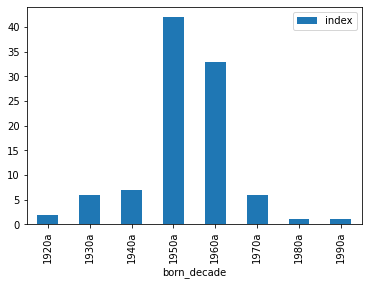

In [64]:
# Plot the result

exec_df[['born_decade']].reset_index().groupby('born_decade').count().plot(kind='bar')
